In [1]:
import sys

sys.path.append('../terrain-erosion-3-ways/')
from river_network import *

sys.path.append("../pipeline")
from svg_extraction import SVGExtractor
from svg_extraction import (
    get_city_coordinates, get_island_coordinates, 
    get_orthogonal_samples)
from image_ops import flood_image
from skimage.segmentation import flood, flood_fill


import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import png
import PIL

import ipywidgets as widgets
from IPython.display import display
import glob

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
realm_selection = widgets.Dropdown(
    options=glob.glob("../svgs/*.svg"),
    description='svg:',
    disabled=False,
)
display(realm_selection)

Dropdown(description='svg:', options=('../svgs/6316.svg', '../svgs/4425.svg', '../svgs/7065.svg', '../svgs/133…

In [3]:
# posisson disc sampling credits to https://github.com/emulbreh/bridson

from random import random, Random
from math import cos, sin, floor, sqrt, pi, ceil

def euclidean_distance(a, b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return dx * dx + dy * dy


def poisson_disc_samples(width, height, r, k=5, distance=euclidean_distance, random=random):
    tau = 2 * pi
    cellsize = r / sqrt(2)

    grid_width = int(ceil(width / cellsize))
    grid_height = int(ceil(height / cellsize))
    grid = [None] * (grid_width * grid_height)

    def grid_coords(p):
        return int(floor(p[0] / cellsize)), int(floor(p[1] / cellsize))

    def fits(p, gx, gy):
        yrange = list(range(max(gy - 2, 0), min(gy + 3, grid_height)))
        sq_r = r*r
        for x in range(max(gx - 2, 0), min(gx + 3, grid_width)):
            for y in yrange:
                g = grid[x + y * grid_width]
                if g is None:
                    continue
                if distance(p, g) <= sq_r:
                    return False
        return True

    p = width * random(), height * random()
    queue = [p]
    grid_x, grid_y = grid_coords(p)
    grid[grid_x + grid_y * grid_width] = p

    while queue:
        qi = int(random() * len(queue))
        qx, qy = queue[qi]
        queue[qi] = queue[-1]
        queue.pop()
        for _ in range(k):
            alpha = tau * random()
            d = r * sqrt(3 * random() + 1)
            px = qx + d * cos(alpha)
            py = qy + d * sin(alpha)
            if not (0 <= px < width and 0 <= py < height):
                continue
            p = (px, py)
            grid_x, grid_y = grid_coords(p)
            if not fits(p, grid_x, grid_y):
                continue
            queue.append(p)
            grid[grid_x + grid_y * grid_width] = p
    p = [p for p in grid if p is not None]
    return np.asarray(p)

def filter_within_bounds(coordinates, width, height):
    filtered_centers = []
    for co in coordinates:
        if 0 <= co[0] < width and 0 <= co[1] < height:
            filtered_centers.append(co)
        else:
            logging.warning(f"out of bounds coordinate!: {co}")
    return filtered_centers

def generate_terrain(
    mask,
    disc_radius=4.,
    max_delta=0.05,
    river_downcutting_constant=5.,
    directional_inertia=0.9,
    default_water_level=1.0,
    evaporation_rate=0.1,
    coastal_dropoff=50., # high: very small slope towards sea, low: abrupt change to sea
    mountain_sigma=1., #low: pikey mountains, #high: bulky mountains
    lakes_alpha=.2, # not sure what this is
    fbm_power=-2,
    mountain_lower=2.0,
    mountain_shape_offset=0.4,
    mountain_offset=0.1
):
    dim = mask.shape[0]
    shape = (dim,) * 2
    print('  ...initial terrain shape')
    land_mask = mask > 0
    coastal_dropoff = np.tanh(util.dist_to_mask(land_mask) / coastal_dropoff) * land_mask
    mountain_shapes = util.fbm(shape, fbm_power, lower=mountain_lower, upper=np.inf)
    initial_height = ( 
      (util.gaussian_blur(np.maximum(mountain_shapes - mountain_shape_offset, 0.0), sigma=mountain_sigma) 
        + mountain_offset) * coastal_dropoff)
    deltas = util.normalize(np.abs(util.gaussian_gradient(initial_height))) 

    print('  ...sampling points')
#     points = util.poisson_disc_sampling(shape, disc_radius)
    prng = Random()
    prng.seed(42)
    points = poisson_disc_samples(*shape, r=disc_radius, random=prng.random)
    coords = np.floor(points).astype(int)

    print('  ...delaunay triangulation')
    tri = sp.spatial.Delaunay(points)
    (indices, indptr) = tri.vertex_neighbor_vertices
    neighbors = [indptr[indices[k]:indices[k + 1]] for k in range(len(points))]
    points_land = land_mask[coords[:, 0], coords[:, 1]]
    points_deltas = deltas[coords[:, 0], coords[:, 1]]

    print('  ...initial height map')
    points_height = compute_height(points, neighbors, points_deltas)

    print('  ...river network')
    (upstream, downstream, volume) = compute_river_network(
      points, neighbors, points_height, points_land,
      directional_inertia, default_water_level, evaporation_rate)

    print('  ...final terrain height')
    new_height = compute_final_height(
      points, neighbors, points_deltas, volume, upstream, 
      max_delta, river_downcutting_constant)
    return render_triangulation(shape, tri, new_height)

def run_pipeline(realm_path, config, debug=True):
    # set some often-used parameters
    svgp = config.svg.padding
    debug_img_size = (10,10)
    extra_scaling = None
    
    realm_number = realm_path.split("/")[-1][:-4]
    logging.info(f"Processing realm number: {realm_number}")
    
    logger.setLevel(logging.INFO)
    logger.info("Setting up extractor")
    extractor = SVGExtractor(realm_path, scale=config.svg.scaling)
    logger.info("\___Done")
    if debug:
        extractor.show(debug_img_size)
        
    logger.info("Extracting coast")
    coast_drawing = extractor.coast()
    coast_img = extractor.get_img()
    logger.info("\___Done")
    
    #############################################
    # MASKING
    #############################################
    
    logger.info("Starting ground-sea mask logic")
    
    logger.info("----Calculating island centers")
    island_centers = get_island_coordinates(
        coast_drawing,
        scaling=config.svg.scaling
    )
    logger.info("    \___Done")
    
    logger.info("----Extracting city centers")
    city_drawing = extractor.cities()
    city_centers = get_city_coordinates(
        city_drawing,
        scaling=config.svg.scaling
    )
    logger.info("    \___Done")
    
    # some small checks
    logger.info("----Filtering centers")
    logger.info("--------Filtering island centers")
    island_centers = filter_within_bounds(island_centers, coast_drawing.width, coast_drawing.height)
    logger.info("        \___Done")
    logger.info("--------Filtering city centers")
    city_centers = filter_within_bounds(city_centers, city_drawing.width, city_drawing.height)
    logger.info("        \___Done")
    
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("coast image with island centers (red) and city centers (green)")
        plt.imshow(coast_img)
        for center in island_centers:
            plt.plot(center[1], center[0], 'ro')
        for center in city_centers:
            plt.plot(center[1], center[0], 'go')
            
    logger.info("----Cropping and flooding areas")
    flooded_image = flood_image(
        coast_img,
        [*city_centers, *island_centers], 
        config.svg.padding
    )
    logger.info("    \___Done")
    
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("Cropped and flooded image")
        plt.imshow(flooded_image)
        plt.show()

    logger.info("----Refining flooded image")
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("sampling locations for refining mask + found centers")
        plt.imshow(flooded_image)
        
    refined_flooded_image = flooded_image.copy()
        
    for path_group in coast_drawing.contents[0].contents:
        path = path_group.contents[0]
        samples1, samples2 = get_orthogonal_samples(path, scaling=config.svg.scaling)
        samples1, samples2 = np.vstack(samples1), np.vstack(samples2)
            
        aggr = []
        for (s1, s2) in zip(samples1, samples2):
            x1, y1 = int(s1[0]-svgp), int(s1[1]-svgp)
            x2, y2 = int(s2[0]-svgp), int(s2[1]-svgp)
            # only add colors if BOTH orthogonals are within bounds
            if 0 <= x1 < flooded_image.shape[0] and 0 <= y1 < flooded_image.shape[1]:
                if 0 <= x2 < flooded_image.shape[0] and 0 <= y2 < flooded_image.shape[1]:
                    aggr.append((flooded_image[y1,x1], flooded_image[y2,x2]))

        if len(aggr) > 3:
            aggr = np.vstack(aggr)
            aggr = np.mean(np.abs(aggr[:,0]-aggr[:,1]))
            if aggr < 10:
                center = np.mean(samples1-svgp, axis=0)
                center = np.clip(center, 0, flooded_image.shape[0]-1)
                refined_flooded_image = flood_fill(
                    refined_flooded_image,
                    (int(center[1]), int(center[0])),
                    0)
                if debug:
                    plt.plot(center[0], center[1], 'go', markersize=5)
        if debug:
            plt.plot(samples1[:,0]-svgp, samples1[:,1]-svgp, 'ro', markersize=1)
            plt.plot(samples2[:,0]-svgp, samples2[:,1]-svgp, 'ro', markersize=1)
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("refined flooded image")
        plt.imshow(refined_flooded_image)
        plt.show()
    logger.info("    \___Done")
    
    logger.info("----Extracting rivers")
    extractor.rivers()
    rivers = np.asarray(extractor.get_img())[svgp:-svgp,svgp:-svgp,0] # rivers is now [0,255]

    rivers = skimage.filters.gaussian(rivers, sigma=1.5) # rivers is now [0,1]
    rivers = (rivers < 0.99)*255
    
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("rivers")
        plt.imshow(rivers)
        plt.show()
    logger.info("    \___Done")
    
    logger.info("----Extracting rivers")
    final_mask = (np.logical_or(flooded_image, rivers)-1)*-255
    anti_final_mask = final_mask*-1+255
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("final water")
        plt.imshow(final_mask)
        plt.show()
    logger.info("    \___Done")
    
    #############################################
    # GENERATION
    #############################################
    
    # image_scaling
    if extra_scaling:
        import scipy.ndimage
        final_mask = scipy.ndimage.zoom(final_mask, 2, order=0)
        anti_final_mask = scipy.ndimage.zoom(anti_final_mask, 2, order=0)
        rivers = scipy.ndimage.zoom(rivers, 2, order=0)

    logger.info("----Terrain generation")
    wpad = config.terrain.water_padding
    if wpad > 0:
        wp = np.zeros(
            (final_mask.shape[0]+2*wpad,
             final_mask.shape[1]+2*wpad))
        wp[wpad:-wpad,wpad:-wpad] = final_mask
        final_mask=wp
    terrain_height = generate_terrain(final_mask, **config.terrain.land)
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("terrain height")
        plt.imshow(terrain_height)
        plt.show()
    logger.info("    \___Done")
    
    logger.info("----Underwater generation")
    wpad = config.terrain.water_padding
    if wpad > 0:
        wp = np.ones(
            (anti_final_mask.shape[0]+2*wpad,
             anti_final_mask.shape[1]+2*wpad))*255
        wp[wpad:-wpad,wpad:-wpad] = anti_final_mask
        anti_final_mask=wp
    water_depth = generate_terrain(anti_final_mask, **config.terrain.water)
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("water depth")
        plt.imshow(water_depth)
        plt.show()
    logger.info("    \___Done")
    
    logger.info("----Combining terrain and water heights")
    m1 = final_mask[wpad:-wpad,wpad:-wpad] if wpad > 0 else final_mask
    _m1 = m1 < 255
    m2 = terrain_height[wpad:-wpad,wpad:-wpad] if wpad > 0 else terrain_height
    m3 = water_depth[wpad:-wpad,wpad:-wpad] if wpad > 0 else water_dept
    combined = m2 - 0.2*_m1*m3
    if debug:
        plt.figure(figsize=debug_img_size)
        plt.title("combined map")
        plt.imshow(combined)
        plt.show()
    logger.info("    \___Done")
    
    #############################################
    # EXPORT 1
    #############################################
    
    logger.info("Exporting height map")
    qmap = (combined-combined.min())/(combined.max()-combined.min())
    qmap = (qmap*255).astype(np.uint8)
    qimg = PIL.Image.fromarray(qmap).convert('L')
    qimg = qimg.resize(
        (config.export.size, config.export.size),
        PIL.Image.NEAREST
    )
    qimg.save(f"../output/height_{realm_number}.png")
    logger.info("\___Done")
    
    #############################################
    # COLORING
    #############################################
    
    logger.info("Coloring")
    def get_color(height):
        if height > .8:
            return np.array([230, 230, 230]) #white
        if height > .55:
            return np.array([158, 158, 158]) #grey
        if height > .45:
            return np.array([100, 100, 100]) #grey
        if height > .4:
            return np.array([120, 174, 106]) #green
        if height > .23:
            return np.array([90, 154, 80]) #green
        if height > .15:
            return np.array([45, 172, 41]) #green
        if height > .10:
            return np.array([100,  100,  76]) #brown
        if height > .05:
            return np.array([100,  76,  76]) #brown
        if height > 0.:
            return np.array([240, 236, 171])
        if height > -0.05:
            return np.array([194, 178, 128])
        if height > -0.07:
            return np.array([151, 149, 130])
        if height > -0.011:
            return np.array([151, 149, 130])-10
        if height > -0.015:
            return np.array([151, 149, 130])-20
        else:
            return np.array([151, 149, 130])-40
        
    colorqmap = np.zeros((*combined.shape, 3))
    
    extractor.rivers()
    rivers = np.asarray(extractor.get_img())[svgp:-svgp,svgp:-svgp,0]
    if extra_scaling:
        rivers = scipy.ndimage.zoom(rivers, 2, order=0) #SCALING
    rivers = (rivers<255)*1
    injected_water_flag = True
    for x in range(combined.shape[0]):
        for y in range(combined.shape[1]):
            colorqmap[x,y,:] = get_color(combined[x,y])
            if rivers[x, y] > 0:
                # colorqmap[x,y,:] = np.array([67, 102, 170]) #4368bc
                if injected_water_flag:
                    colorqmap[x,y,:] = np.array([74, 134, 168])
                    injected_water_flag = False
    if debug:
        plt.hist(combined.flatten(), bins=50)[2]
        plt.show()
        plt.imshow(colorqmap/255)
        plt.show()
    logger.info("\___Done")
    
    #############################################
    # EXPORT 2
    #############################################
    
    logger.info("Exporting color map")
    colorqmap_export = colorqmap.astype(np.uint8)
    colorqmap_export = PIL.Image.fromarray(colorqmap_export)
    colorqmap_export = colorqmap_export.resize(
        (config.export.size, config.export.size),
        PIL.Image.NEAREST
    )
    colorqmap_export.save(f"../output/color_{realm_number}.png")
    logger.info("\___Done")

INFO:root:Processing realm number: 6316
INFO:root:Setting up extractor
INFO:root:\___Done


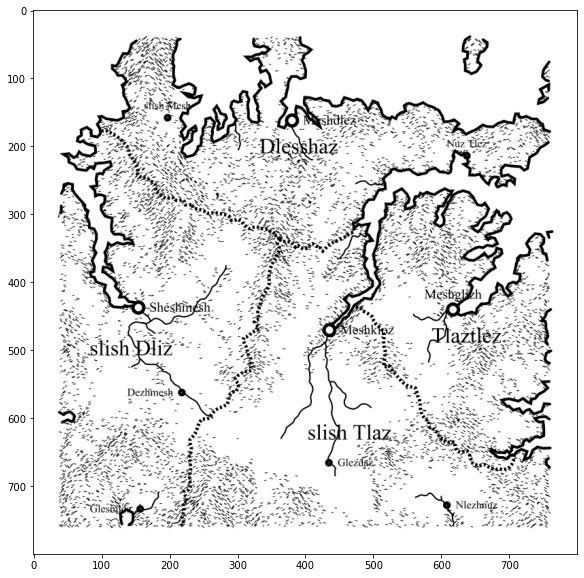

INFO:root:Extracting coast
INFO:root:\___Done
INFO:root:Starting ground-sea mask logic
INFO:root:----Calculating island centers
INFO:root:    \___Done
INFO:root:----Extracting city centers
INFO:root:    \___Done
INFO:root:----Filtering centers
INFO:root:--------Filtering island centers
INFO:root:        \___Done
INFO:root:--------Filtering city centers
INFO:root:        \___Done
INFO:root:----Cropping and flooding areas
INFO:root:    \___Done


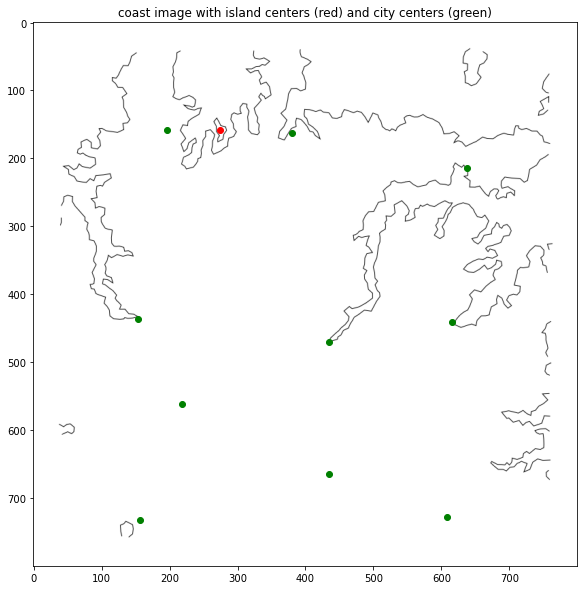

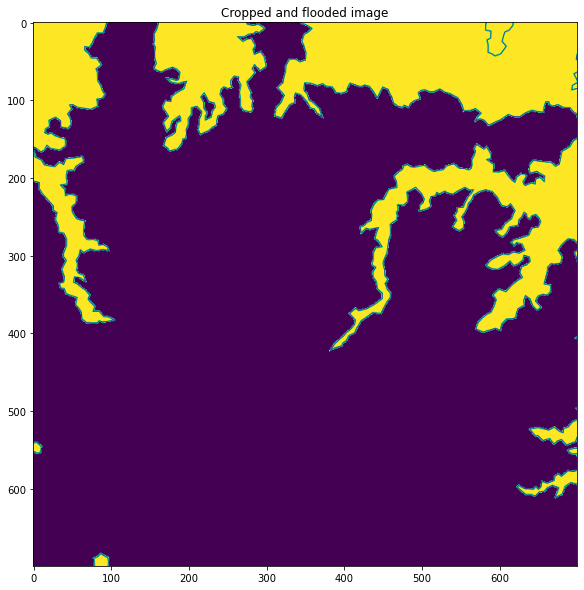

INFO:root:----Refining flooded image


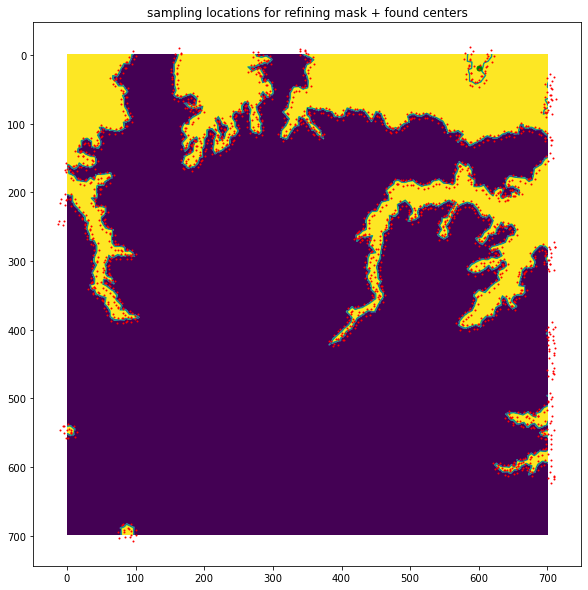

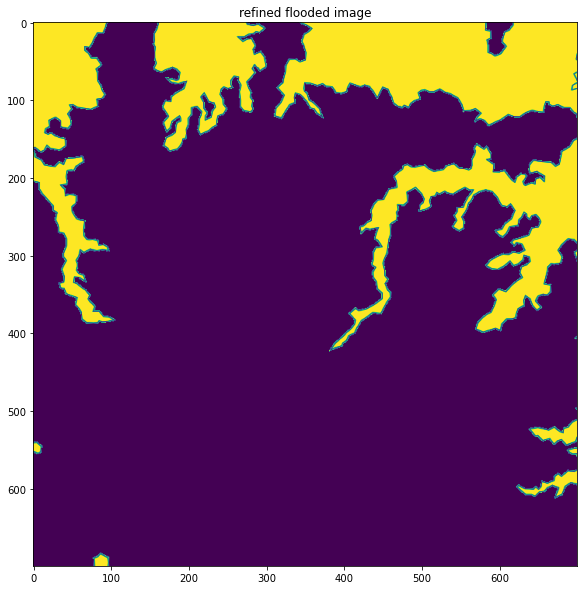

INFO:root:    \___Done
INFO:root:----Extracting rivers


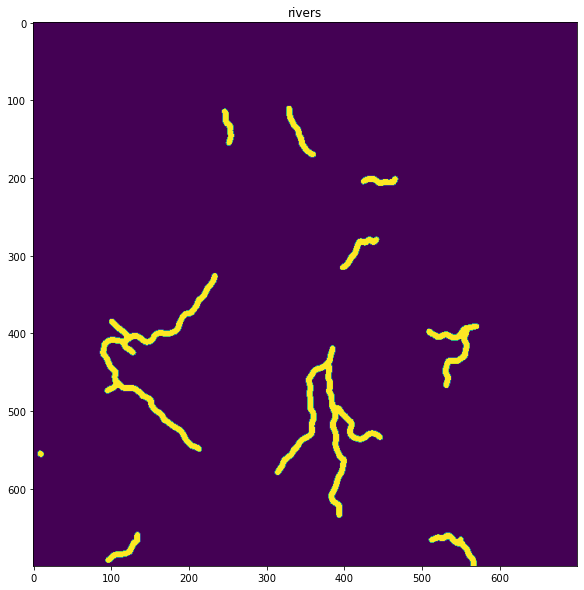

INFO:root:    \___Done
INFO:root:----Extracting rivers


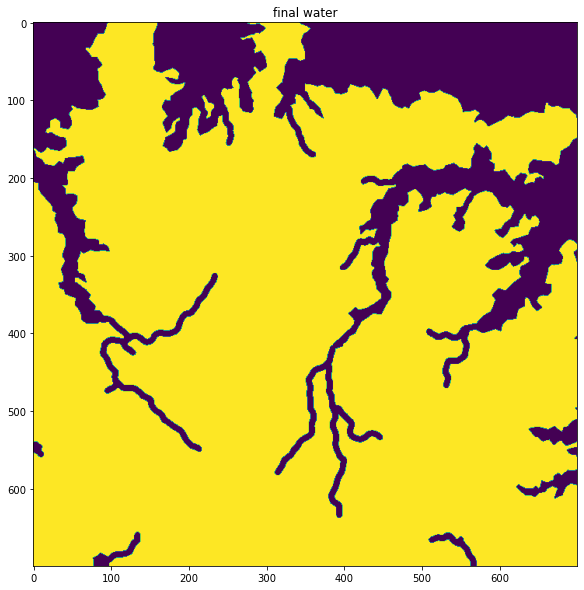

INFO:root:    \___Done
INFO:root:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


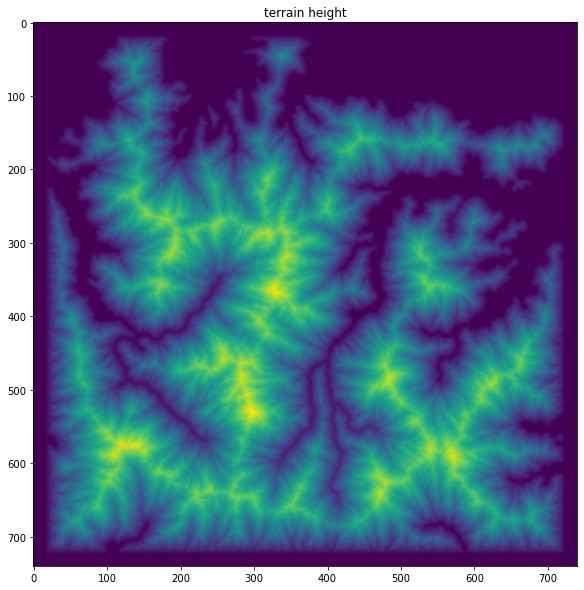

INFO:root:    \___Done
INFO:root:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


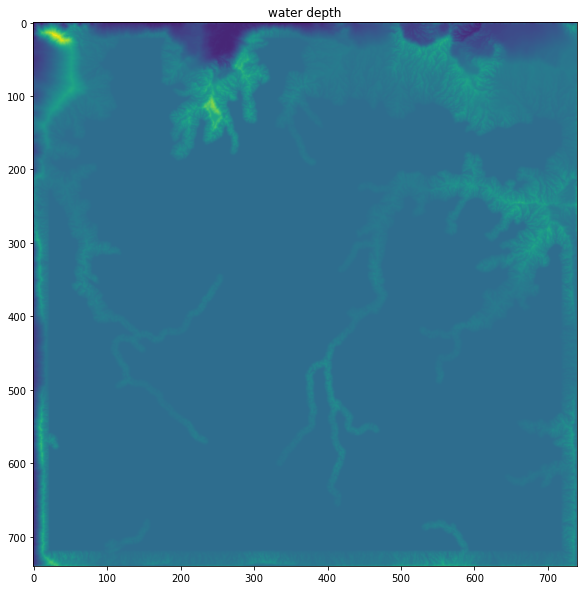

INFO:root:    \___Done
INFO:root:----Combining terrain and water heights


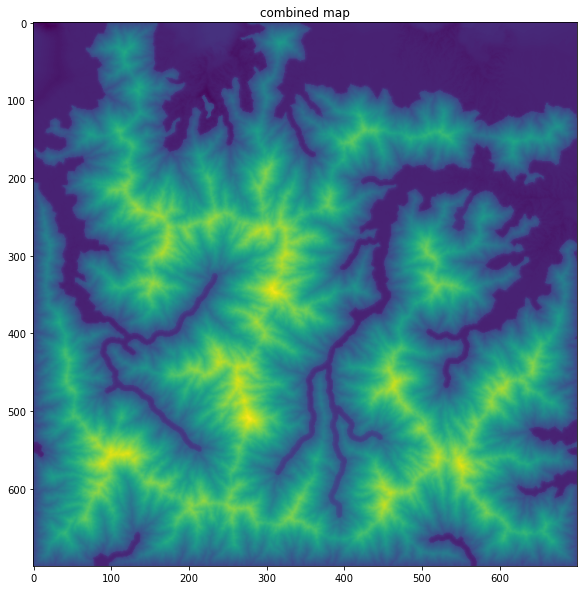

INFO:root:    \___Done
INFO:root:Exporting height map
INFO:root:\___Done
INFO:root:Coloring


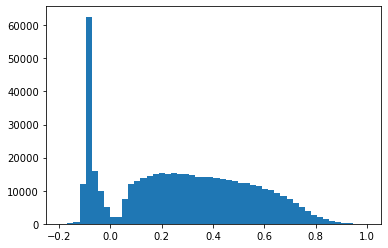

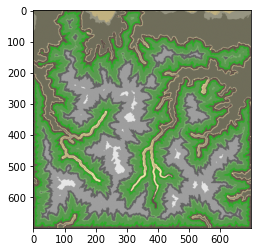

INFO:root:\___Done
INFO:root:Exporting color map
INFO:root:\___Done


In [4]:
config = OmegaConf.load("../pipeline/config.yaml")

run_pipeline(realm_selection.value, config)

In [5]:
# config = OmegaConf.load("../pipeline/config.yaml")
# for svg in glob.glob("../svgs/*.svg"):
#     run_pipeline(svg, config, debug=False)

## exp

INFO:root:Processing realm number: 6316
INFO:root:Setting up extractor
INFO:root:\___Done


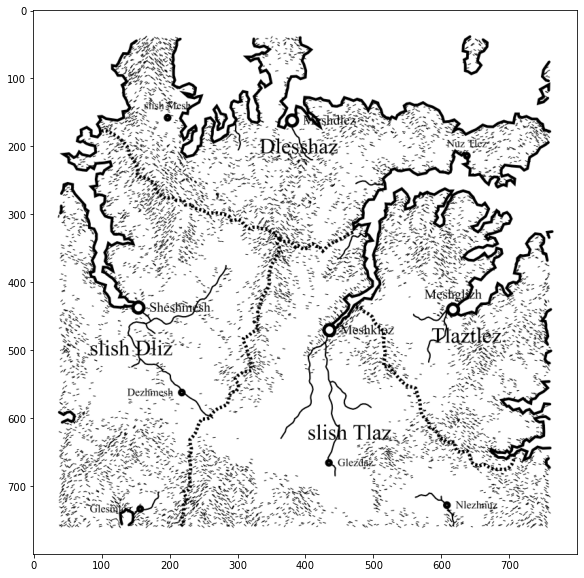

INFO:root:Extracting coast
INFO:root:\___Done
INFO:root:Starting ground-sea mask logic
INFO:root:----Calculating island centers
INFO:root:    \___Done
INFO:root:----Extracting city centers
INFO:root:    \___Done
INFO:root:----Filtering centers
INFO:root:--------Filtering island centers
INFO:root:        \___Done
INFO:root:--------Filtering city centers
INFO:root:        \___Done
INFO:root:----Cropping and flooding areas
INFO:root:    \___Done


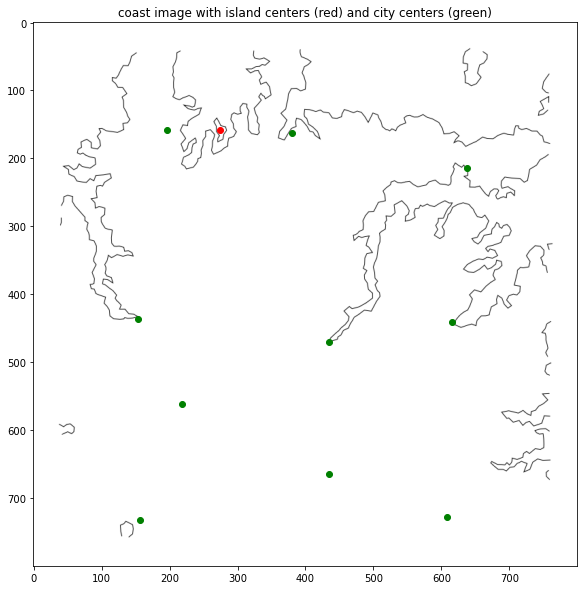

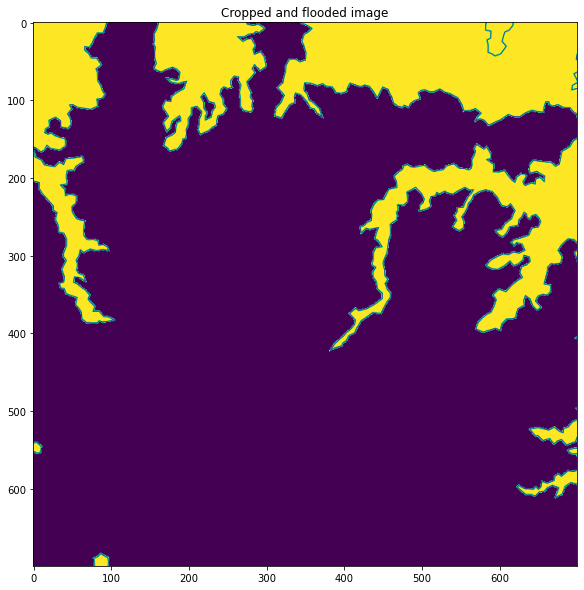

INFO:root:----Refining flooded image


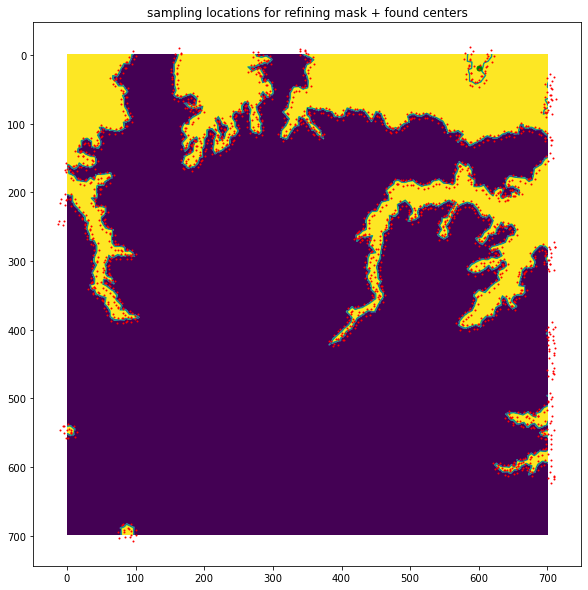

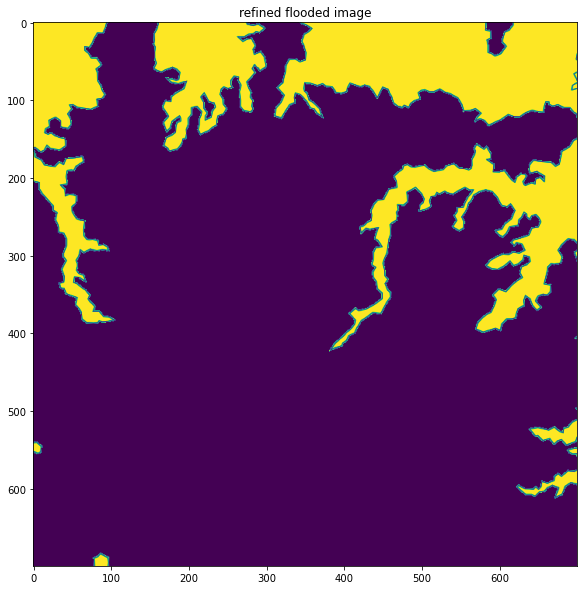

INFO:root:    \___Done
INFO:root:----Extracting rivers


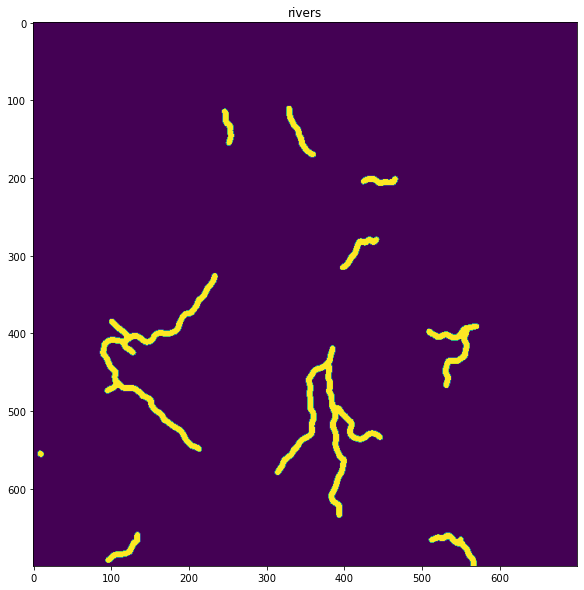

INFO:root:    \___Done
INFO:root:----Extracting rivers


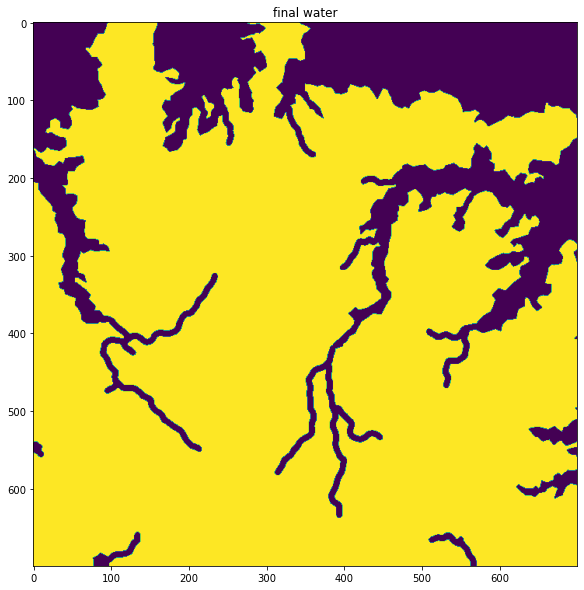

INFO:root:    \___Done
INFO:root:----Terrain generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


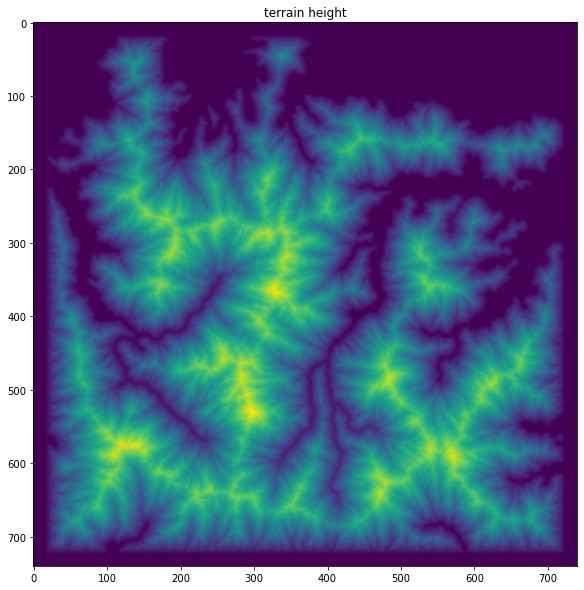

INFO:root:    \___Done
INFO:root:----Underwater generation


  ...initial terrain shape
  ...sampling points
  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


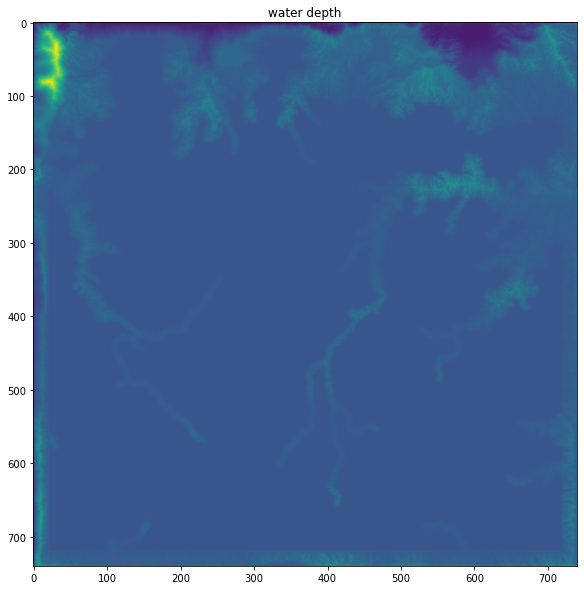

INFO:root:    \___Done
INFO:root:----Combining terrain and water heights


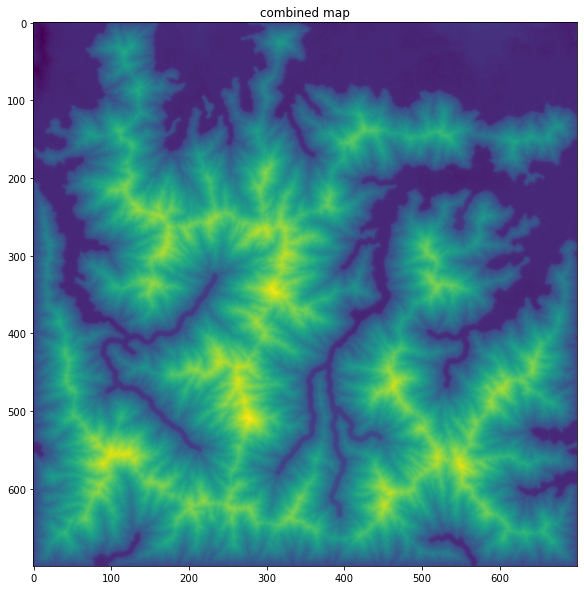

INFO:root:    \___Done
INFO:root:Exporting height map
INFO:root:\___Done


In [6]:
realm_path = realm_selection.value
debug = True

# set some often-used parameters
svgp = config.svg.padding
debug_img_size = (10,10)
extra_scaling = None

realm_number = realm_path.split("/")[-1][:-4]
logging.info(f"Processing realm number: {realm_number}")

logger.setLevel(logging.INFO)
logger.info("Setting up extractor")
extractor = SVGExtractor(realm_path, scale=config.svg.scaling)
logger.info("\___Done")
if debug:
    extractor.show(debug_img_size)

logger.info("Extracting coast")
coast_drawing = extractor.coast()
coast_img = extractor.get_img()
logger.info("\___Done")

#############################################
# MASKING
#############################################

logger.info("Starting ground-sea mask logic")

logger.info("----Calculating island centers")
island_centers = get_island_coordinates(
    coast_drawing,
    scaling=config.svg.scaling
)
logger.info("    \___Done")

logger.info("----Extracting city centers")
city_drawing = extractor.cities()
city_centers = get_city_coordinates(
    city_drawing,
    scaling=config.svg.scaling
)
logger.info("    \___Done")

# some small checks
logger.info("----Filtering centers")
logger.info("--------Filtering island centers")
island_centers = filter_within_bounds(island_centers, coast_drawing.width, coast_drawing.height)
logger.info("        \___Done")
logger.info("--------Filtering city centers")
city_centers = filter_within_bounds(city_centers, city_drawing.width, city_drawing.height)
logger.info("        \___Done")

if debug:
    plt.figure(figsize=debug_img_size)
    plt.title("coast image with island centers (red) and city centers (green)")
    plt.imshow(coast_img)
    for center in island_centers:
        plt.plot(center[1], center[0], 'ro')
    for center in city_centers:
        plt.plot(center[1], center[0], 'go')

logger.info("----Cropping and flooding areas")
flooded_image = flood_image(
    coast_img,
    [*city_centers, *island_centers], 
    config.svg.padding
)
logger.info("    \___Done")

if debug:
    plt.figure(figsize=debug_img_size)
    plt.title("Cropped and flooded image")
    plt.imshow(flooded_image)
    plt.show()

logger.info("----Refining flooded image")
if debug:
    plt.figure(figsize=debug_img_size)
    plt.title("sampling locations for refining mask + found centers")
    plt.imshow(flooded_image)

refined_flooded_image = flooded_image.copy()

for path_group in coast_drawing.contents[0].contents:
    path = path_group.contents[0]
    samples1, samples2 = get_orthogonal_samples(path, scaling=config.svg.scaling)
    samples1, samples2 = np.vstack(samples1), np.vstack(samples2)

    aggr = []
    for (s1, s2) in zip(samples1, samples2):
        x1, y1 = int(s1[0]-svgp), int(s1[1]-svgp)
        x2, y2 = int(s2[0]-svgp), int(s2[1]-svgp)
        # only add colors if BOTH orthogonals are within bounds
        if 0 <= x1 < flooded_image.shape[0] and 0 <= y1 < flooded_image.shape[1]:
            if 0 <= x2 < flooded_image.shape[0] and 0 <= y2 < flooded_image.shape[1]:
                aggr.append((flooded_image[y1,x1], flooded_image[y2,x2]))

    if len(aggr) > 3:
        aggr = np.vstack(aggr)
        aggr = np.mean(np.abs(aggr[:,0]-aggr[:,1]))
        if aggr < 10:
            center = np.mean(samples1-svgp, axis=0)
            center = np.clip(center, 0, flooded_image.shape[0]-1)
            refined_flooded_image = flood_fill(
                refined_flooded_image,
                (int(center[1]), int(center[0])),
                0)
            if debug:
                plt.plot(center[0], center[1], 'go', markersize=5)
    if debug:
        plt.plot(samples1[:,0]-svgp, samples1[:,1]-svgp, 'ro', markersize=1)
        plt.plot(samples2[:,0]-svgp, samples2[:,1]-svgp, 'ro', markersize=1)
if debug:
    plt.figure(figsize=debug_img_size)
    plt.title("refined flooded image")
    plt.imshow(refined_flooded_image)
    plt.show()
logger.info("    \___Done")

logger.info("----Extracting rivers")
extractor.rivers()
rivers = np.asarray(extractor.get_img())[svgp:-svgp,svgp:-svgp,0] # rivers is now [0,255]

rivers = skimage.filters.gaussian(rivers, sigma=1.5) # rivers is now [0,1]
rivers = (rivers < 0.99)*255

if debug:
    plt.figure(figsize=debug_img_size)
    plt.title("rivers")
    plt.imshow(rivers)
    plt.show()
logger.info("    \___Done")

logger.info("----Extracting rivers")
final_mask = (np.logical_or(flooded_image, rivers)-1)*-255
anti_final_mask = final_mask*-1+255
if debug:
    plt.figure(figsize=debug_img_size)
    plt.title("final water")
    plt.imshow(final_mask)
    plt.show()
logger.info("    \___Done")

#############################################
# GENERATION
#############################################

# image_scaling
if extra_scaling:
    import scipy.ndimage
    final_mask = scipy.ndimage.zoom(final_mask, 2, order=0)
    anti_final_mask = scipy.ndimage.zoom(anti_final_mask, 2, order=0)
    rivers = scipy.ndimage.zoom(rivers, 2, order=0)

logger.info("----Terrain generation")
wpad = config.terrain.water_padding
if wpad > 0:
    wp = np.zeros(
        (final_mask.shape[0]+2*wpad,
         final_mask.shape[1]+2*wpad))
    wp[wpad:-wpad,wpad:-wpad] = final_mask
    final_mask=wp
terrain_height = generate_terrain(final_mask, **config.terrain.land)
if debug:
    plt.figure(figsize=debug_img_size)
    plt.title("terrain height")
    plt.imshow(terrain_height)
    plt.show()
logger.info("    \___Done")

logger.info("----Underwater generation")
wpad = config.terrain.water_padding
if wpad > 0:
    wp = np.ones(
        (anti_final_mask.shape[0]+2*wpad,
         anti_final_mask.shape[1]+2*wpad))*255
    wp[wpad:-wpad,wpad:-wpad] = anti_final_mask
    anti_final_mask=wp
water_depth = generate_terrain(anti_final_mask, **config.terrain.water)
if debug:
    plt.figure(figsize=debug_img_size)
    plt.title("water depth")
    plt.imshow(water_depth)
    plt.show()
logger.info("    \___Done")

logger.info("----Combining terrain and water heights")
m1 = final_mask[wpad:-wpad,wpad:-wpad] if wpad > 0 else final_mask
_m1 = m1 < 255
m2 = terrain_height[wpad:-wpad,wpad:-wpad] if wpad > 0 else terrain_height
m3 = water_depth[wpad:-wpad,wpad:-wpad] if wpad > 0 else water_dept
combined = m2 - 0.2*_m1*m3
if debug:
    plt.figure(figsize=debug_img_size)
    plt.title("combined map")
    plt.imshow(combined)
    plt.show()
logger.info("    \___Done")

#############################################
# EXPORT 1
#############################################

logger.info("Exporting height map")
qmap = (combined-combined.min())/(combined.max()-combined.min())
qmap = (qmap*255).astype(np.uint8)
qimg = PIL.Image.fromarray(qmap).convert('L')
qimg = qimg.resize(
    (config.export.size, config.export.size),
    PIL.Image.NEAREST
)
qimg.save(f"../output/height_{realm_number}.png")
logger.info("\___Done")



INFO:root:Coloring


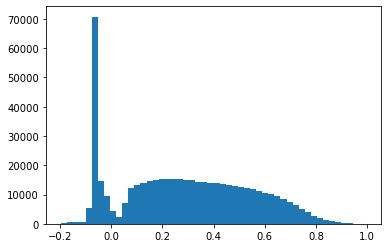

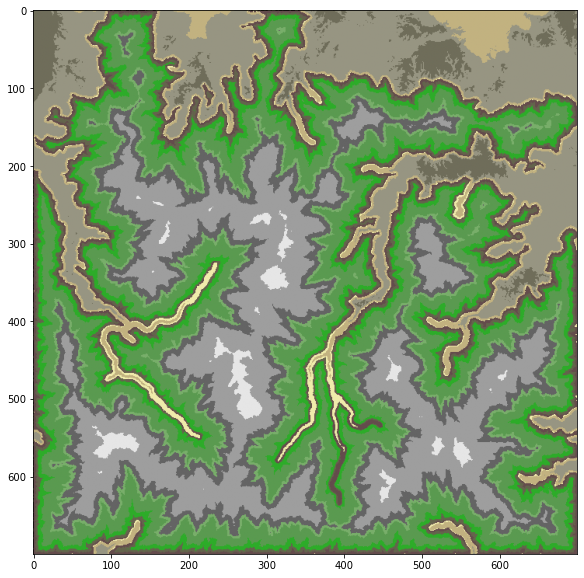

INFO:root:\___Done


In [7]:
#############################################
# COLORING
#############################################

logger.info("Coloring")
def get_color(height):
    if height > .8:
        return np.array([230, 230, 230]) #white
    if height > .55:
        return np.array([158, 158, 158]) #grey
    if height > .45:
        return np.array([100, 100, 100]) #grey
    if height > .4:
        return np.array([120, 174, 106]) #green
    if height > .23:
        return np.array([90, 154, 80]) #green
    if height > .15:
        return np.array([45, 172, 41]) #green
    if height > .10:
        return np.array([100,  100,  76]) #brown
    if height > .05:
        return np.array([100,  76,  76]) #brown
    if height > 0.:
        return np.array([240, 236, 171])
    if height > -0.05:
        return np.array([194, 178, 128])
    if height > -0.07:
        return np.array([151, 149, 130])
    if height > -0.011:
        return np.array([151, 149, 130])-10
    if height > -0.015:
        return np.array([151, 149, 130])-20
    else:
        return np.array([151, 149, 130])-40

colorqmap = np.zeros((*combined.shape, 3))

extractor.rivers()
rivers = np.asarray(extractor.get_img())[svgp:-svgp,svgp:-svgp,0]
if extra_scaling:
    rivers = scipy.ndimage.zoom(rivers, 2, order=0) #SCALING
rivers = (rivers<255)*1
injected_water_flag = True
for x in range(combined.shape[0]):
    for y in range(combined.shape[1]):
        colorqmap[x,y,:] = get_color(combined[x,y])
        if rivers[x, y] > 0:
            # colorqmap[x,y,:] = np.array([67, 102, 170]) #4368bc
            if injected_water_flag:
                colorqmap[x,y,:] = np.array([74, 134, 168])
                injected_water_flag = False
if debug:
    plt.hist(combined.flatten(), bins=50)[2]
    plt.show()
    plt.figure(figsize=debug_img_size)
    plt.imshow(colorqmap/255)
    plt.show()
logger.info("\___Done")

False


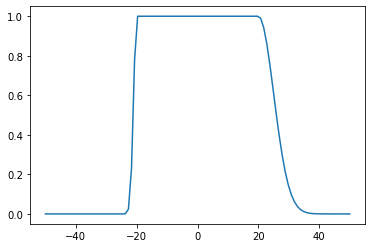

In [8]:
import random
def gaussian(x, mu1, mu2, sig):
    if isinstance(sig, list):
        sig1 = sig[0]
        sig2 = sig[1]
    else:
        sig1 = sig2 = sig
    gl = np.exp(-np.power(x - mu1, 2.) / (2 * np.power(sig1, 2.)))
    gr = np.exp(-np.power(x - mu2, 2.) / (2 * np.power(sig2, 2.)))
    return np.clip(np.where(((mu1 < x) & (x < mu2)), 1, gl+gr),0, 1)

def color_pass(h, lo, hi, sigma=2):
    p = gaussian(h, lo, hi, sigma)
    return random.random() < p
    
x = np.linspace(-50,50,100)
plt.plot(x, gaussian(x,-20,20,[1,5]))

print(color_pass(-30, -20, 20, 5))

In [9]:
colorqmap = np.zeros((*combined.shape, 3))

extractor.rivers()
rivers = np.asarray(extractor.get_img())[svgp:-svgp,svgp:-svgp,0]
if extra_scaling:
    rivers = scipy.ndimage.zoom(rivers, 2, order=0) #SCALING
rivers = (rivers<255)*1
injected_water_flag = True

2
0


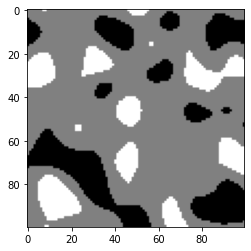

In [10]:
from perlin_noise.perlin_noise import PerlinNoise
noise = PerlinNoise(octaves=5, seed=1)

xpix, ypix = 100, 100
pic = [[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]

def quantize(x, k=3):
    x += 0.5
    x = np.clip(x,0,0.99)
    return int(x/(1/k))

pic = [[quantize(noise([i/xpix, j/ypix])) for j in range(xpix)] for i in range(ypix)]

print(max(max(pic)))
print(min(min(pic)))
plt.imshow(pic, cmap='gray')
plt.show()

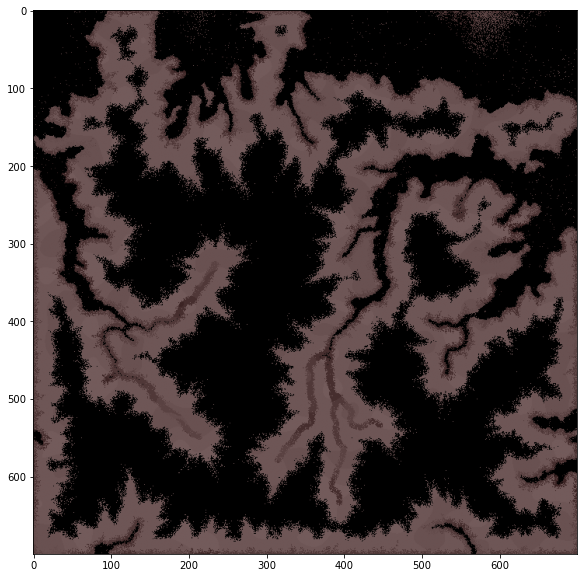

In [11]:
noise = PerlinNoise(octaves=2, seed=1)

# dirt pass
for x in range(combined.shape[0]):
    for y in range(combined.shape[1]):
        if color_pass(combined[x,y], .0, .2, 0.02):
            colors = [
                np.array([100,  76,  76]) ,
                np.array([100,  76,  76]) - 10,
                np.array([100,  76,  76]) - 20,
                np.array([100,  76,  76]) - 30,
                np.array([100,  76,  76]) - 40,
            ]
            colorqmap[x,y,:] = colors[quantize(noise([x/100, y/100]), len(colors))]
            
        if color_pass(combined[x,y], .2, .3, 0.07):
            colors = [
                np.array([100,  76,  76]) + 5,
                np.array([100,  76,  76]) + 10,
                np.array([100,  76,  76]) + 15,
            ]
            colorqmap[x,y,:] = colors[quantize(noise([x/100, y/100]), len(colors))]

plt.figure(figsize=debug_img_size)
plt.imshow(colorqmap/255)
plt.show()

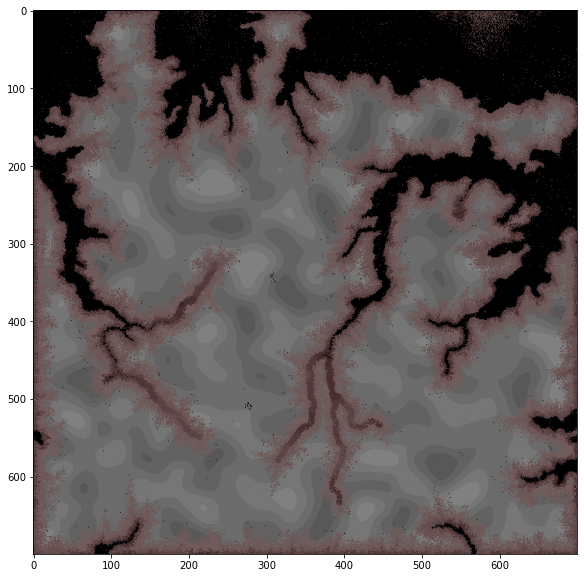

In [12]:
# stone pass
for x in range(combined.shape[0]):
    for y in range(combined.shape[1]):
        if color_pass(combined[x,y], .4, .9, 0.1):
            colors = [
                np.array([128,  128,  128]) ,
                np.array([128,  128,  128]) - 10,
                np.array([128,  128,  128]) - 20,
                np.array([128,  128,  128]) - 30,
                np.array([128,  128,  128]) - 40,
            ]
            colorqmap[x,y,:] = colors[quantize(noise([x/100, y/100]), len(colors))]

plt.figure(figsize=debug_img_size)
plt.imshow(colorqmap/255)
plt.show()

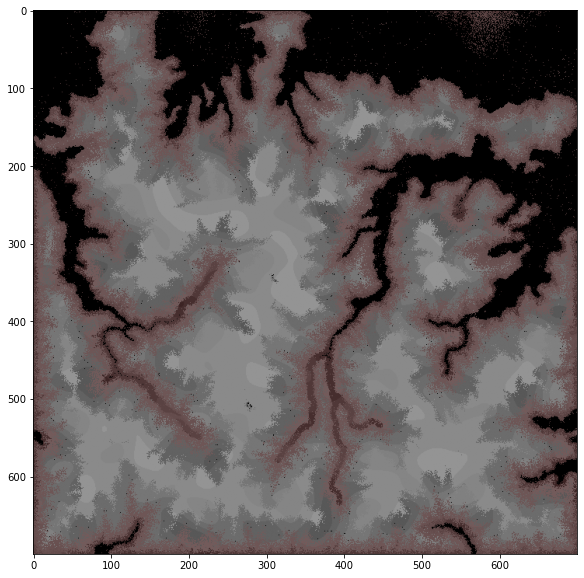

In [13]:
# stone pass
for x in range(combined.shape[0]):
    for y in range(combined.shape[1]):
        if color_pass(combined[x,y], .6, .9, 0.05):
            colors = [
                np.array([128,  128,  128]) + 5,
                np.array([128,  128,  128]) + 10,
                np.array([128,  128,  128]) + 20,
            ]
            colorqmap[x,y,:] = colors[quantize(noise([x/100, y/100]), len(colors))]

plt.figure(figsize=debug_img_size)
plt.imshow(colorqmap/255)
plt.show()

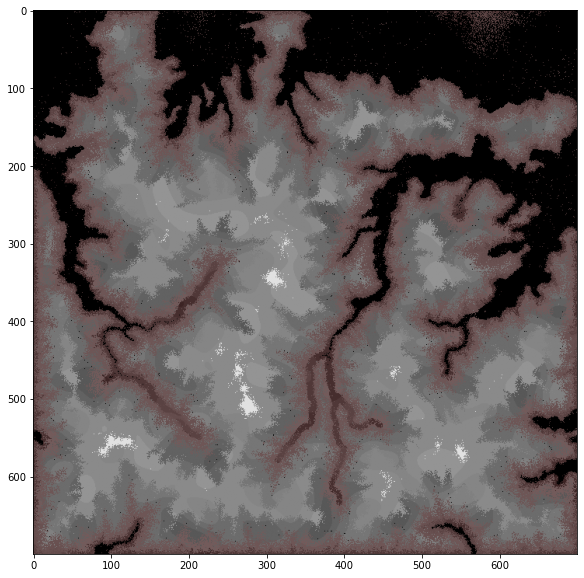

In [14]:
# snow pass
for x in range(combined.shape[0]):
    for y in range(combined.shape[1]):
        if color_pass(combined[x,y], 0.93, 1., 0.05):
            colorqmap[x,y,:] = np.array([225, 225, 225])

plt.figure(figsize=debug_img_size)
plt.imshow(colorqmap/255)
plt.show()

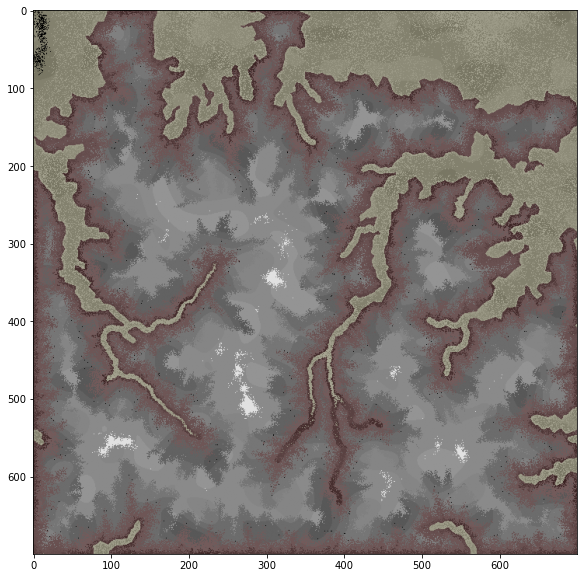

In [15]:
# sand pass
for x in range(combined.shape[0]):
    for y in range(combined.shape[1]):
        if color_pass(combined[x,y], -0.1, 0.01, 0.01):
            colors = [
                np.array([151, 149, 130]) + 5,
                np.array([151, 149, 130]) + 10,
                np.array([151, 149, 130]) + 15,
            ]
            colorqmap[x,y,:] = colors[quantize(noise([x/100, y/100]), len(colors))]
        if color_pass(combined[x,y], -0.1, -0.3, 0.05):
            colors = [
                np.array([151, 149, 130]) - 10,
                np.array([151, 149, 130]) - 20,
                np.array([151, 149, 130]) - 30,
            ]
            colorqmap[x,y,:] = colors[quantize(noise([x/100, y/100]), len(colors))]

plt.figure(figsize=debug_img_size)
plt.imshow(colorqmap/255)
plt.show()

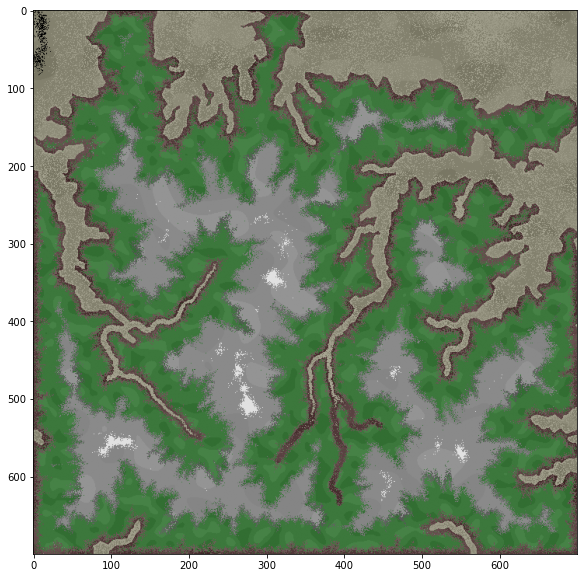

In [16]:
noise = PerlinNoise(octaves=5, seed=1)

# grass pass
for x in range(combined.shape[0]):
    for y in range(combined.shape[1]):
        if color_pass(combined[x,y], 0.25, 0.4, 0.07):
            colors = [
                np.array([80, 140, 80]) - 10,
                np.array([80, 140, 80]) - 20,
                np.array([80, 140, 80]) - 30,
            ]
            colorqmap[x,y,:] = colors[quantize(noise([x/100, y/100]), len(colors))]

plt.figure(figsize=debug_img_size)
plt.imshow(colorqmap/255)
plt.show()

In [17]:
def process_color(x, y, lo, hi, spread, color, color_diffs):
    if color_pass(combined[x,y], lo, hi, spread):
        colors = [
            color + i
            for i in color_diffs
        ]
        return colors[quantize(noise([x/100, y/100]), len(colors))]
    else:
        return None

def dirt_1(x, y):
    color = np.array([100,  76,  76])
    color_diffs = [0, -10, -20, -30, -40]
    return process_color(x, y, .0, .2, 0.02, color, color_diffs)

def dirt_2(x, y):
    color = np.array([100,  76,  76])
    color_diffs = [0, 5, 10, 15]
    return process_color(x, y, .2, .3, 0.07, color, color_diffs)

def stone_1(x, y):
    color = np.array([128,  128,  128])
    color_diffs = [0, -10, -20, -30, -40]
    return process_color(x, y, -1., .9, 0.1, color, color_diffs)

def stone_2(x, y):
    color = np.array([128,  128,  128])
    color_diffs = [5, 10, 20]
    return process_color(x, y, .6, .9, 0.05, color, color_diffs)

def snow(x, y):
    color = np.array([225, 225, 225])
    color_diffs = [0]
    return process_color(x, y, 0.93, 1., 0.05, color, color_diffs)

def sand_1(x, y):
    color = np.array([151, 149, 130])
    color_diffs = [5, 10, 15]
    return process_color(x, y, -0.1, 0.01, 0.01, color, color_diffs)

def sand_2(x, y):
    color = np.array([151, 149, 130])
    color_diffs = [-10, -20, -30]
    return process_color(x, y, -0.1, -0.3, 0.05, color, color_diffs)

def grass_1(x, y):
    color = np.array([80, 140, 80])
    color_diffs = [-10, -20, -30]
    return process_color(x, y, 0.25, 0.4, 0.07, color, color_diffs)

def grass_2(x, y):
    color = np.array((60, 117, 55))
    color_diffs = [-15, 0, 15]
    return process_color(x, y, 0.3, 0.35, 0.05, color, color_diffs)

In [18]:
color_functions = [
    stone_1,
    dirt_1,
    dirt_2,
    stone_2,
    snow,
    sand_1,
    sand_2,
    grass_1,
    grass_2,
]

100%|█████████████████████████████████████████| 700/700 [03:15<00:00,  3.58it/s]

195.36171102523804


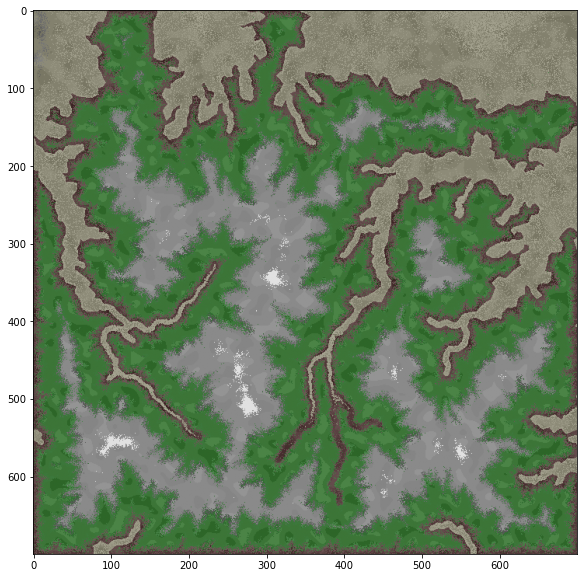

In [19]:
colorqmap = np.zeros((*combined.shape, 3))
import time
from tqdm import tqdm

start = time.time()
for x in tqdm(range(combined.shape[0])):
    for y in range(combined.shape[1]):
        for cf in color_functions:
            c = cf(x, y)
            if c is not None:
                colorqmap[x,y,:] = c
print(time.time()-start)
                
plt.figure(figsize=debug_img_size)
plt.imshow(colorqmap/255)
plt.show()

# np vectorization

In [21]:
from perlin_numpy import (
    generate_fractal_noise_2d, generate_fractal_noise_3d,
    generate_perlin_noise_2d, generate_perlin_noise_3d
)

100%|█████████████████████████████████████████| 350/350 [00:41<00:00,  8.37it/s]


41.8344612121582


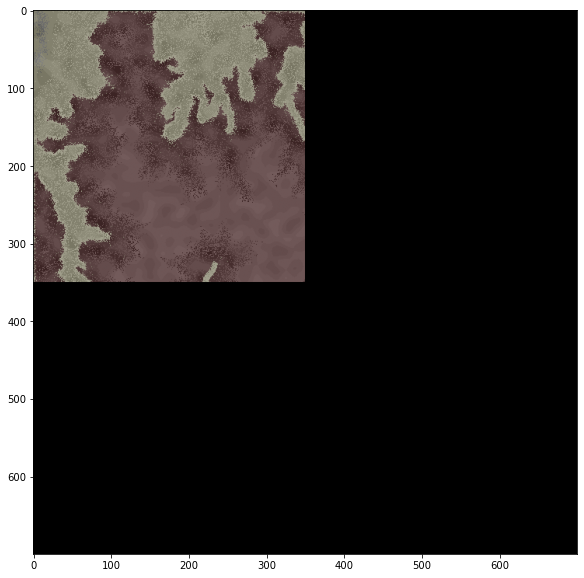

In [20]:
combined_bak = combined.copy()
combined = np.where(combined>0,combined*0.3,combined)

color_functions = [
    stone_1,
    dirt_1,
    dirt_2,
    stone_2,
    sand_1,
    sand_2,
]

colorqmap = np.zeros((*combined.shape, 3))

start = time.time()
for x in tqdm(range(combined.shape[0])[:combined.shape[0]//2]):
    for y in range(combined.shape[1])[:combined.shape[0]//2]:
        for cf in color_functions:
            c = cf(x, y)
            if c is not None:
                colorqmap[x,y,:] = c
print(time.time()-start)
                
plt.figure(figsize=debug_img_size)
plt.imshow(colorqmap/255)
plt.show()

In [22]:
np.linspace(-0.6,0.6,4)

array([-0.6, -0.2,  0.2,  0.6])

In [38]:
def colorize_perlin(hmap, mu, sig, perlin_res, color, color_diffs):
    if isinstance(mu, list):
        mu1, mu2 = mu
    else:
        mu1 = mu2 = mu
    if isinstance(sig, list):
        sig1, sig2 = sig
    else:
        sig1 = sig2 = sig
    gl = np.exp(-np.power(hmap - mu1, 2.) / (2 * np.power(sig1, 2.)))
    gr = np.exp(-np.power(hmap - mu2, 2.) / (2 * np.power(sig2, 2.)))
    ans = np.clip(np.where(((mu1 < hmap) & (hmap < mu2)), 1, gl+gr),0, 1)

    ps = np.random.random((hmap.shape))

    needs_coloring = ps < ans
    pnoise = generate_perlin_noise_2d(hmap.shape, [perlin_res,perlin_res])
    pnoise = np.digitize(pnoise, np.linspace(-0.6,0.6,len(color_diffs)-1))

    select_idx = needs_coloring * pnoise

    colors = [color+cdiff for cdiff in color_diffs]

    final = np.expand_dims(needs_coloring, -1)*np.take(colors, select_idx, axis=0)

#     if debug:
#         plt.figure(figsize=debug_img_size)
#         plt.imshow(needs_coloring)
#         plt.show()
#         plt.figure(figsize=debug_img_size)
#         plt.imshow(pnoise)
#         plt.show()
#         plt.figure(figsize=debug_img_size)
#         plt.imshow(final)
#         plt.show()
    
    return final

In [128]:
def overlap(base, overlay):
    return np.where(overlay.sum(axis=-1, keepdims=True)>0, overlay, base)

def dirt_1():
    mu, sig = [0.0, 0.1], [0.01, 0.1]
    perlin_res = 10
    color = np.array([100,  76,  76])
    color_diffs = [+20, +10, 0, -10, -20]
    return colorize_perlin(combined, mu, sig, perlin_res, color, color_diffs)

def dirt_2():
    mu, sig = [0.2, 0.22], 0.07
    perlin_res = 20
    color = np.array([100,  76,  76])
    color_diffs = [0, 5, 10, 15]
    return colorize_perlin(combined, mu, sig, perlin_res, color, color_diffs)

def stone_1():
    mu, sig = [-1.0, 0.9], 0.1
    perlin_res = 1
    color = np.array([128,  128,  128])
    color_diffs = [+20, +10, 0, -10, -20]
    return colorize_perlin(combined, mu, sig, perlin_res, color, color_diffs)

def stone_2():
    mu, sig = [0.6, 0.9], 0.05
    perlin_res = 10
    color = np.array([128,  128,  128])
    color_diffs = [5, 10, 20]
    return colorize_perlin(combined, mu, sig, perlin_res, color, color_diffs)

def snow():
    mu, sig = [0.93, 1.0], 0.05
    perlin_res = 10
    color = np.array([225, 225, 225])
    color_diffs = [-5, 0]
    return colorize_perlin(combined, mu, sig, perlin_res, color, color_diffs)

def sand_1():
    mu, sig = [-0.1, 0.01], 0.01
    perlin_res = 10
    color = np.array([151, 149, 130])
    color_diffs = [5, 10, 15]
    return colorize_perlin(combined, mu, sig, perlin_res, color, color_diffs)

def sand_2():
    mu, sig = [-0.1, -0.3], 0.05
    perlin_res = 10
    color = np.array([151, 149, 130])
    color_diffs = [-10, -20, -30]
    return colorize_perlin(combined, mu, sig, perlin_res, color, color_diffs)

def grass_1():
    mu, sig = [0.25, 0.4], 0.07
    perlin_res = 10
    color = np.array([80, 140, 80])
    color_diffs = [-10, -20, -30]
    return colorize_perlin(combined, mu, sig, perlin_res, color, color_diffs)

def grass_2():
    mu, sig = [0.3, 0.35], 0.05
    perlin_res = 10
    color = np.array((60, 117, 55))
    color_diffs = [-15, 0, 15]
    return colorize_perlin(combined, mu, sig, perlin_res, color, color_diffs)

In [129]:
def run_coloring(color_functions):
    x = np.zeros((*combined.shape, 3))
    for cfn in color_functions:
        y = cfn()
        x = overlap(x, y)
        print(cfn)
        plt.figure(figsize=debug_img_size)
        plt.imshow(x/255)
        plt.show()
    return x

In [130]:
moderate = [
    stone_1,
    dirt_1
]

<function stone_1 at 0x1349caaf0>


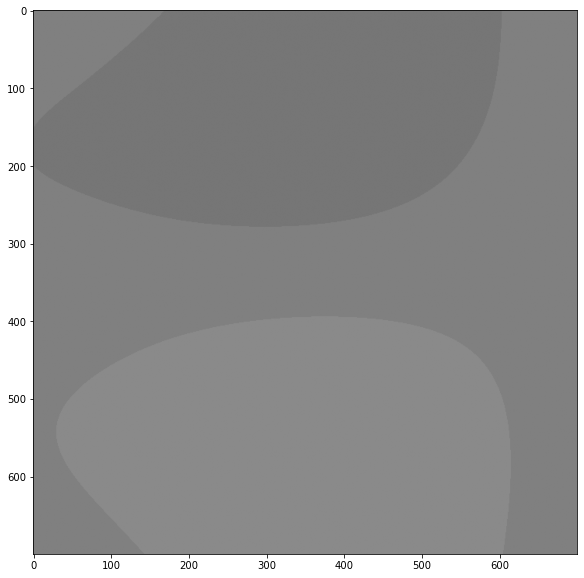

<function dirt_1 at 0x1331c0b80>


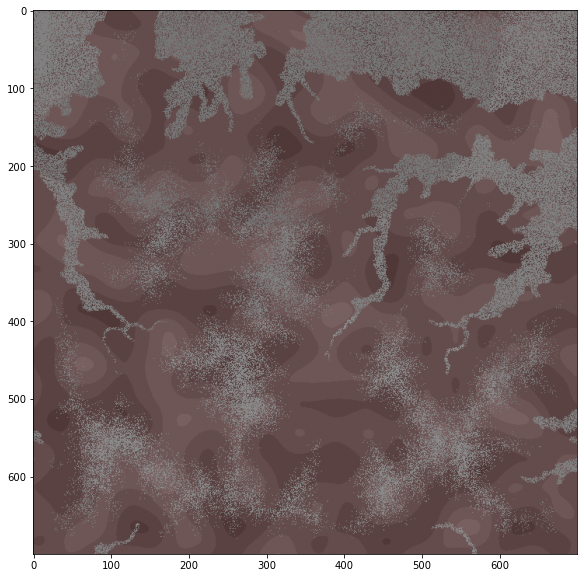

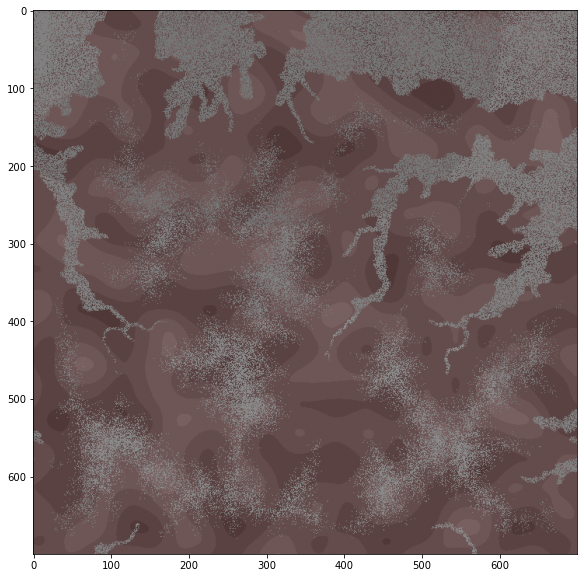

In [131]:
final = run_coloring(moderate)
plt.figure(figsize=debug_img_size)
plt.imshow(final/255)

In [24]:
cd = CDirt1()
cd.colorize()

NameError: name 'CDirt1' is not defined